# **前日の20:00までのデータを用いて翌日の00:00~23:30までの発電量をMLPで予測する**

### **必要な関数・ライブラリ**

In [26]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from new_MLP import MLP
import os

%matplotlib inline

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [4]:
def set_datetime(x):
    '''
    指定されたdatetime形式になるように整形
    '''
    str_month = str(x.month)
    if x.month - 10 < 0:
        str_month = "0"+str(x.month)
    str_day = str(x.day)
    if x.day - 10 < 0:
        str_day = "0"+str(x.day)
    str_hour = str(x.hour)
    if x.hour - 10 < 0:
        str_hour = "0"+str(x.hour)
    str_minute = str(x.minute)
    if x.minute == 0:
        str_minute = "00"
    if x.minute == 0 and x.hour == 0:
        str_minute = "00"
        str_hour = "24"
        str_day = str(x.day - 1)
        if (x.day - 1) - 10 < 0:
            str_day = "0"+str(x.day - 1)
                              
    return str(x.year)+str_month+str_day+str_hour+str_minute

In [5]:
def add_hour_month(input_data):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data = input_data.drop(['hour', 'minute', 'month'], axis=1)
    return input_data

In [6]:
def get_30(tmp_data):
    '''
    必要なカラムだけ拾ってきて30分ごのデータに整形
    '''
    tmp_data = tmp_data[["datetime", "pr", "max_ws", "ave_ws", "max_tp", "min_tp", "sl"]]
    
    # 欠損値を一つ前の値で置換/output_data
    tmp_data = tmp_data.fillna(method='bfill')
    tmp_30 = tmp_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    # datetimeのカラムを復活させる
    tmp_30['datetime'] = tmp_30.index
    tmp_30.index = np.arange(len(tmp_30))
    tmp_30.head()
    return tmp_30

In [7]:
def normalize_array(x):
    '''
    min, max, min-max正規化を行なった配列(np.array)を返す
    '''
    x = np.array(x)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min) 
    return x_min, x_max, normalized

In [8]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [9]:
def get_input_data(X):
    '''
    全時系列データから00:00 ~ 20:00までのデータごとに分割する
    '''
    input_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(X) // 48
    reshaped_size = X[0:41].shape[0] * X[0:41].shape[1]
    for i in range(total_size+1):
        each_data = X[(i*48):(i*48+41)]
        reshaped = each_data.reshape(reshaped_size)
        input_list.append(list(reshaped))
    input_list = np.array(input_list)
    return input_list

In [10]:
def get_output_data(Y):
    '''
    全時系列データから00:00 ~ 23:30までのデータごとに分割する
    '''
    output_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(Y) // 48
    for i in range(total_size):
        each_data = Y[(i*48):(i*48+48)]
        reshaped = each_data.reshape(48)
        output_list.append(list(reshaped))
    output_list = np.array(output_list)
    return output_list

In [11]:
def drop_nan(X, Y):
    '''
    Yにnanが含まれるペアを削除(他のとこにあるdrop_nanとは別物なので注意)
    '''
    mask = []
    for i in range(len(Y)):
        if np.isnan(Y[i]).sum() == 0:
            mask.append(True)
        else:
            mask.append(False)
    X = X[mask]
    Y = Y[mask]
    return X, Y

In [12]:
def calc_mae(X, Y):
    '''
    X, Yがメモリを食いすぎるのでfor文で計算
    '''
    mse = 0
    for i in range(len(X)):
        mse += np.abs(X[i]- Y[i])
    return mse/len(X)

### **データの準備**

In [13]:
target_place = 1

In [14]:
# 発電量データ
output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
output_30['datetime'] = output_30['datetime'].map(lambda x : pd.to_datetime(x))
output_30 = output_30[['datetime', 'SOLA0'+str(target_place)]]

In [15]:
# 発電所近くのamedas
# アメダスデータの読み込み
if target_place == 1 or target_place == 2:
    # 対象アメダスは横浜アメダス, amd_46106
    # 各amdidはamd_masterに記載されている
    target_amd_data = pd.read_csv('data/raw_data/amd_46106.tsv', delimiter = '\t')
    target_amd_data = set_time(target_amd_data, 'datetime')
    target_amd_data['datetime'] = target_amd_data['datetime'].map(lambda x : pd.to_datetime(x))
elif target_place == 3:
    # 甲府アメダスのデータを使って予測する, amd_49142
    # 各amdidはamd_masterに記載されている
    target_amd_data = pd.read_csv('data/raw_data/amd_49142.tsv', delimiter = '\t')
    target_amd_data = set_time(target_amd_data, 'datetime')
    target_amd_data['datetime'] = target_amd_data['datetime'].map(lambda x : pd.to_datetime(x))
else:
    raise ValueError("invalid input target_place")

In [16]:
# 欠損値を一つ前の値で置換/output_data
target_amd_data = target_amd_data.fillna(method='bfill')
# target_30 = target_amd_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

# datetimeのカラムを復活させる
# target_30['datetime'] = target_30.index
# target_30 = target_30[['datetime', 'sl']]
# target_30.index = np.arange(len(target_30))
# target_30.head()

In [17]:
suffix = 1
result = get_30(target_amd_data)

In [18]:
# 名古屋アメダスのデータを使って予測する, amd_51106
# 各amdidはamd_masterに記載されている
tmp_data = pd.read_csv('data/raw_data/amd_51106.tsv', delimiter = '\t')
tmp_data = set_time(tmp_data, 'datetime')
tmp_data['datetime'] = tmp_data['datetime'].map(lambda x : pd.to_datetime(x))    
tmp_30 = get_30(tmp_data)
result = pd.merge(tmp_30, result, on='datetime', suffixes = ('_'+str(suffix), '_'+str(suffix+1)))
suffix += 2

In [19]:
# 浜松のデータamd_50456を加える
tmp_data = pd.read_csv('data/raw_data/amd_50456.tsv', delimiter = '\t')
tmp_data = set_time(tmp_data, 'datetime')
tmp_data['datetime'] = tmp_data['datetime'].map(lambda x : pd.to_datetime(x))
tmp_30 = get_30(tmp_data)
result = pd.merge(result, tmp_30, on='datetime', suffixes = ('_'+str(suffix), '_'+str(suffix+1)))
suffix += 2

In [20]:
# 大阪のデータamd_62078を加える
tmp_data = pd.read_csv('data/raw_data/amd_50456.tsv', delimiter = '\t')
tmp_data = set_time(tmp_data, 'datetime')
tmp_data['datetime'] = tmp_data['datetime'].map(lambda x : pd.to_datetime(x))
tmp_30 = get_30(tmp_data)
result = pd.merge(result, tmp_30, on='datetime', suffixes = ('_'+str(suffix), '_'+str(suffix+1)))
suffix += 2

In [21]:
# 飯田のデータamd_62078を加える
tmp_data = pd.read_csv('data/raw_data/amd_48767.tsv', delimiter = '\t')
tmp_data = set_time(tmp_data, 'datetime')
tmp_data['datetime'] = tmp_data['datetime'].map(lambda x : pd.to_datetime(x))
tmp_30 = get_30(tmp_data)
result = pd.merge(result, tmp_30, on='datetime', suffixes = ('_'+str(suffix), '_'+str(suffix+1)))
suffix += 2

In [22]:
# モデル構築のためにデータを分割する

# 学習に必要なデータ
# 前日の00:00 ~ 20:00のデータで翌日の0:00 ~ 23:30を予測する
train_x_s_idx = result[result['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_x_e_idx = result[result['datetime'] == pd.to_datetime('2015-12-30 20:00')].index[0]
train_y_s_idx = result[result['datetime'] == pd.to_datetime('2012-01-02 00:00')].index[0]
train_y_e_idx = result[result['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

output_kwh = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
input_data = result.drop(["datetime"], axis=1)[train_x_s_idx:train_x_e_idx+1]
# output_sl = target_30["sl"][train_y_s_idx:train_y_e_idx+1]

# 予測に必要なデータ
# 前日の00:00 ~ 20:00のデータで翌日の0:00 ~ 23:30を予測する
test_x_s_idx = result[result['datetime'] == pd.to_datetime('2015-12-31 00:00')].index[0]
test_x_e_idx = result[result['datetime'] == pd.to_datetime('2017-3-30 20:00')].index[0]
# test_y_s_idx = amd_30[amd_30['datetime'] == pd.to_datetime('2016-1-1 00:00')].index[0]
# test_y_e_idx = amd_30[amd_30['datetime'] == pd.to_datetime('2017-3-31 23:30')].index[0]


test_input_data = result.drop(["datetime"], axis=1)[test_x_s_idx:test_x_e_idx+1]
# test_output_sl = target_30[["sl"]][test_y_s_idx:test_y_e_idx+1]

In [23]:
# MLPに突っ込むための準備をする

# min-max正規化しておく
normalized_input = (input_data - input_data.min()) / (input_data.max() - input_data.min())
normalized_input = np.array(normalized_input)
normalized_kwh = (output_kwh - output_kwh.min()) /( output_kwh.max() - output_kwh.min())
normalized_kwh = np.array(normalized_kwh)
# normalized_output = (output_sl - output_sl.min()) / (output_sl.max() - output_sl.min())
# normalized_output = np.array(normalized_output)

input_list = get_input_data(normalized_input)
kwh_list = get_output_data(normalized_kwh)
# output_list = get_output_data(normalized_output)

filtered_input_list, filtered_kwh_list = drop_nan(input_list, kwh_list)

# testデータの入力を用意
normalized_test_input = (test_input_data - test_input_data.min()) / (test_input_data.max() - test_input_data.min())
normalized_test_input = np.array(normalized_test_input)

test_input_list = get_input_data(normalized_test_input)

# denormalize用
kwh_max = float(output_kwh.max())
kwh_min = float(output_kwh.min())
# output_max = float(output_sl.max())
# output_min = float(output_sl.min())

# MLPに突っ込むためにデータを整形
X = np.array(filtered_input_list).reshape(filtered_input_list.shape[0], filtered_input_list.shape[1])
all_X = np.array(input_list).reshape(input_list.shape[0], input_list.shape[1])
KWH = np.array(filtered_kwh_list).reshape(filtered_kwh_list.shape[0],filtered_kwh_list.shape[1])
X_predict = np.array(test_input_list).reshape(test_input_list.shape[0], test_input_list.shape[1])
# Y = np.array(normalized_output).reshape(output_list.shape[0], output_list.shape[1])

### **モデルの構築**

条件:翌日の気温を予測するには前日の20:00までの気象情報しか使えない

モデル:翌日の30分毎の気温を前日の20:00までの各所のアメダスの気象情報で予測させる

入力:各所のアメダス情報をひとまとめにした配列

出力:0:00, 0:30, .... , 23:00, 23:30の気温の配列

とりあえず一つの箇所のデータを使って予測


In [373]:
# 学習済みモデルを使用するさいはこちらを
model_name = "targetplace_3_kwh_kouhu_nagoya_hamamatsu_osaka_hannou_one_layer_5000"
epochs = 2000

In [27]:
epochs = 1000
hidden_size = 50
batch_size = 100
activation = "sigmoid"
model_name = "test"
batch_normalization = False
try:
    os.mkdir('./data/model/'+model_name)
    print("make save directory")
except :
    print("directory already exists")

print(model_name)

directory already exists
test


In [28]:
X_train, X_val, Y_train, Y_val = train_test_split(X, KWH, test_size=0.33)

In [29]:
mlp_model = MLP(X_train, Y_train, X_val, Y_val, epochs = epochs, hidden_size = hidden_size, batch_size = batch_size, model_name = model_name, activation = activation, batch_normalization = batch_normalization)

In [30]:
validation_losses = mlp_model.train()

train#0, validation loss: 5.528636e-01
train#20, validation loss: 3.554228e-02
train#40, validation loss: 2.498360e-02
train#60, validation loss: 2.066594e-02
train#80, validation loss: 1.950508e-02
train#100, validation loss: 1.831550e-02
train#120, validation loss: 1.784001e-02
train#140, validation loss: 1.733430e-02
train#160, validation loss: 1.686663e-02
train#180, validation loss: 1.677847e-02
train#200, validation loss: 1.625224e-02
train#220, validation loss: 1.578641e-02
train#240, validation loss: 1.580546e-02
train#260, validation loss: 1.613323e-02
train#280, validation loss: 1.577206e-02
train#300, validation loss: 1.567140e-02
train#320, validation loss: 1.581832e-02
train#340, validation loss: 1.659168e-02
do early stopping


[0.5528636,
 0.035542279,
 0.024983598,
 0.020665944,
 0.019505078,
 0.018315496,
 0.017840005,
 0.017334301,
 0.016866628,
 0.016778467,
 0.016252236,
 0.015786406,
 0.015805457,
 0.016133228,
 0.015772056,
 0.015671397,
 0.015818322]

In [31]:
predictions = mlp_model.predict(X)[0]
predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1])
processed_prediction = denormalize_array(predictions, kwh_min, kwh_max)

In [32]:
true = denormalize_array(filtered_kwh_list.reshape(filtered_kwh_list.shape[0] * filtered_kwh_list.shape[1]), kwh_min, kwh_max)

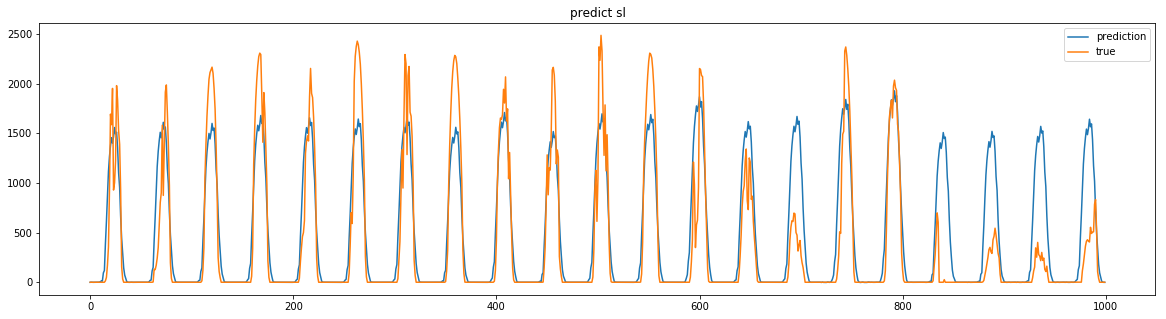

In [33]:
plt.figure(figsize=(20, 5))
plt.plot(processed_prediction[0:1000], label = "prediction")
plt.plot(true[0:1000], label = "true")
plt.legend()
plt.title("predict sl")

In [34]:
print('training mae :', calc_mae(processed_prediction, true))

training mae : 225.746261261


In [36]:
validation = mlp_model.predict(mlp_model.X_val)[0]
validation = validation.reshape(validation.shape[0] * validation.shape[1])
processed_validation = denormalize_array(validation, kwh_min, kwh_max)

In [37]:
Y_val = mlp_model.Y_val
Y_val = Y_val.reshape(Y_val.shape[0] * Y_val.shape[1])
Y_val = denormalize_array(Y_val, kwh_min, kwh_max)

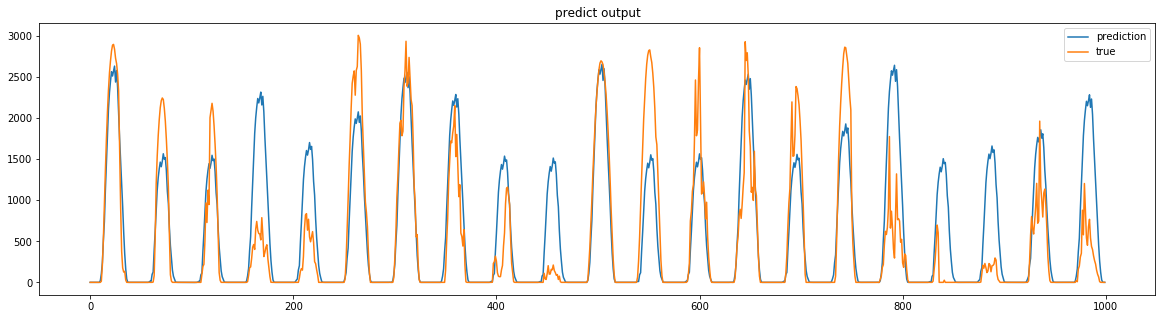

In [38]:
plt.figure(figsize=(20, 5))
plt.plot(processed_validation[0:1000], label = "prediction")
plt.plot(Y_val[0:1000], label = "true")
plt.legend()
plt.title("predict output")

In [39]:
print('validation mae :', calc_mae(processed_validation, Y_val))

validation mae : 232.531498256


In [35]:
predictions = mlp_model.predict(all_X)[0]
predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1])
processed_prediction = denormalize_array(predictions, kwh_min, kwh_max)

In [382]:
try:
    predict_data = pd.read_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', delimiter='\t')
    
except FileNotFoundError:
    s_idx = result[result['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = result[result['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [383]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data[model_name] = processed_prediction

In [384]:
predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [389]:
# X_predictによる予測
predictions = mlp_model.predict(X_predict)[0]
predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1])
processed_prediction = denormalize_array(predictions, kwh_min, kwh_max)

In [390]:
processed_prediction

array([ 0.42791021,  0.71211761,  0.83429188, ...,  0.95520335,
        0.84356612,  0.66623944], dtype=float32)

In [391]:
try:
    predict_data = pd.read_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', delimiter='\t')
    
except FileNotFoundError:
    s_idx = result[result['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = result[result['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [392]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data[model_name] = processed_prediction

In [393]:
predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)